In [139]:
from pyraysum import prs, Geometry, Model, Control
import numpy as np

In [140]:
def all(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani, scale = 20, print_model = False, plot_model = False):
    thickn = np.array(thickn) * 1000
    flag = [1 if i == 0 else 0 for i in ani]
    model = Model(thickn, rho, vp, vs=vs, strike=strike, dip=dip, flag=flag, plunge=plunge, trend=Trend, ani = ani)
    if print_model:
        print("The Model configuration is as below:")
        print(model)
    # print(plunge, Trend, ani)
    geom = Geometry(baz, slow)
    npts = 1500
    dt = 0.0125 
    rc = Control(rot=1, mults=1, verbose=False, npts=npts, dt=dt)
    result = prs.run(model, geom, rc, rf=True)
    result.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
    if plot_model:
        model.plot()
        result.plot('rfs', tmin=-0.5, tmax = npts*dt*0.5, scale = scale)
    
    return model, geom, result

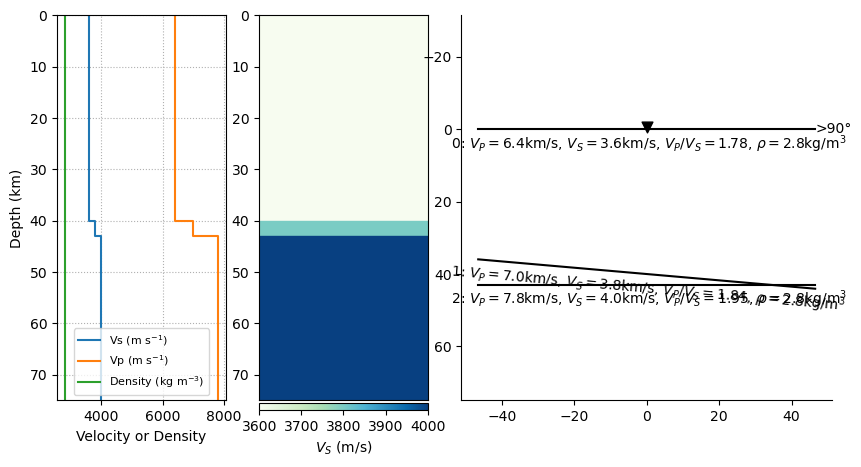

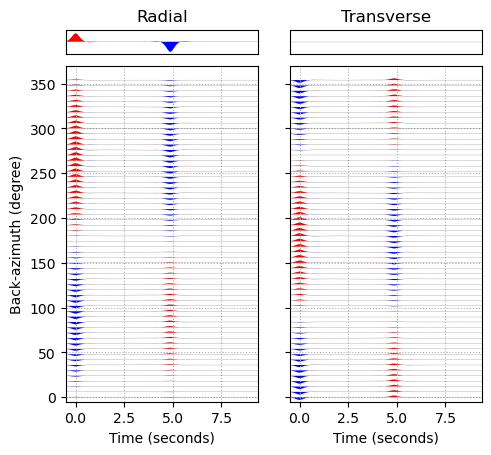

In [141]:
baz = np.arange(0., 360., 6.)
slow = 0.003
thickn = [40, 3, 0]   #km
rho = [2800, 2800, 2800]
vp = [6400, 7000, 7800]
vs = [3600, 3800, 4000]
#plane geometry
dip = [0, 5, -0]       #degrees
strike = [0, -0, -0]
#ansitropy
plunge = [0, 0, 0]
trend = [0, 0, 0]
ani = [0, 0, 0]

model, geom, result = all(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani, scale = 500, print_model = False, plot_model = True)

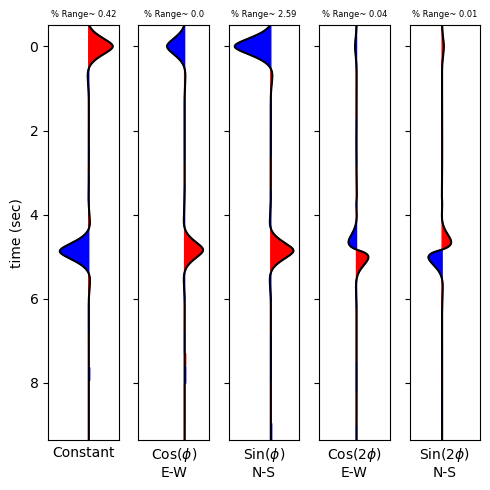

In [142]:
from codes_RF.prs_utils import *

X, time = harm_dec_calc(result, sig_len = 1500)
plot_har_dec(X, time)